In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import torchmetrics as tm
import seaborn as sns
from matplotlib import pyplot as plt
import re
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
SESSION_DIR_PATH = Path("../../session")
DATA_DIR_PATH = Path("../../data")
SESSION_DIR_PATH = Path("../../session")
TRAIN_DATASET_PATH = DATA_DIR_PATH.joinpath("jigsaw2019-train.csv")
TEST_DATASET_PATH = DATA_DIR_PATH.joinpath("jigsaw2019-test.csv")
LABEL_LIST = ['toxicity', 'obscene', 'sexual_explicit',
            'identity_attack', 'insult', 'threat']
IDENTITY_LIST = ['male', 'female', 'transgender', 'other_gender', 'heterosexual',
                'homosexual_gay_or_lesbian', 'bisexual','other_sexual_orientation',
                'christian', 'jewish', 'muslim', 'hindu','buddhist', 'atheist',
                'other_religion', 'black', 'white', 'asian', 'latino',
                'other_race_or_ethnicity', 'physical_disability',
                'intellectual_or_learning_disability',
                'psychiatric_or_mental_illness','other_disability']
SELECTED_IDENTITY_LIST = ['male', 'female', 'black', 'white', 'homosexual_gay_or_lesbian',
                    'christian', 'jewish', 'muslim', 'psychiatric_or_mental_illness']

SELECTED_SESSION_INFO = [('pierre-roberta-bce_2022-04-01T15-53-15-127273', 'BERT', 134088961, 0.153711),
                        ('pierre-roberta-pwbce_2022-04-01T00-16-50-635795', 'BERT', 134088961, 0.15284),
                        ('pierre-roberta-fl_2022-04-01T20-43-05-082657', 'BERT', 134088961, 0.154159),
                        ('pierre-roberta-pwfl_2022-04-01T20-44-35-459744', 'BERT', 134088961, 0.154602),
                        ('pierre-albert-pwbce_2022-04-02T08-52-15-316727', 'BERT', 21142278, 0.177142),
                        ('pierre-distilbert-pwbce_2022-04-02T08-51-40-340808', 'BERT', 75821574, 0.089415),
                        ('pierre-hatebert-pwbce_2022-04-02T14-16-41-524853', 'BERT', 118940934, 0.171139),
                        ('pierre-xlmroberta-pwbce_2022-04-02T14-48-21-276717', 'BERT', 287502342, 0.152607),
                        ('pierre-xlnet-pwbce_2022-04-02T18-31-29-083854', 'XLNet', 126177030, 0.242603),
                        ('pierre-bertweet-pwbce_2022-04-03T03-03-05-377047', 'BERT', 144358662, 0.1533),
                        ('pierre-unfreezed-glove-resnet44-pwbce_2022-04-03T03-07-30-490184', 'CNN', 26274138, 0.071897),
                        ('pierre-freezed-glove-resnet44-pwbce_2022-04-03T10-58-39-295726', 'CNN', 658038, 0.073078),
                        ('pierre-glove-bigru-pwbce_2022-04-03T18-21-04-474521', 'RNN', 27665706, 0.03195),
                        ('pierre-glove-bilstm-pwbce_2022-04-03T20-20-15-399610', 'RNN', 28348106, 0.034753),
                        ('glove-cct-pwbce_2022-04-03T22-49-02-960730', 'CCT', 62132971, 0.204585),
                        ('pierre-unfreezed-glove-resnet56-pwbce_2022-04-06T13-32-28-490973', 'CNN', 26468570, 0.08401)]

SELECTED_SESSION_NAME = [name for name, _,  _, _ in SELECTED_SESSION_INFO]
SELECTED_SESSION_PARAMS = [params for _, _, params, _ in SELECTED_SESSION_INFO]
SELECTED_SESSION_BATCHTIME = [batchtime for _, _, _, batchtime in SELECTED_SESSION_INFO]

In [3]:
validation_dataset_namespace = lambda session_name: f"{session_name}.jigsaw2019-validation.csv"
log_namespace = lambda session_name: f"{session_name}.loguru.log"
metric_namespace = lambda session_name: f"{session_name}.metric.json"
test_prediction_namespace = lambda session_name: f"{session_name}.test.csv"
validation_prediction_namespace = lambda session_name: f"{session_name}.validation.csv"

## Metrics en général

In [4]:
# Adapted from : https://gist.github.com/aditya-5842/b2a886f42bc9988dc11c1737a349830c

from sklearn.metrics import roc_auc_score

########################################################################################
#######################     function to calculate the AUC        #######################
########################################################################################

def cal_auc(y_true, y_pred):
    "returns the auc value"
    return roc_auc_score(y_true, y_pred)

########################################################################################
#######################  function to calculate the Subgroup AUC  #######################
########################################################################################

def cal_subgroup_auc(target_df, prediction_df, subgroups, label):
    subgroup_filter = target_df[subgroups] == 1
    return cal_auc(target_df[subgroup_filter][label], prediction_df[subgroup_filter][label])

########################################################################################
#######################   function to calculate the BPSN AUC     #######################
########################################################################################

def cal_bpsn_auc(target_df, prediction_df, subgroups, label):
    """This will calculate the BPSN auc"""
    subgroup_filter = target_df[subgroups] == 1
    positive_label_filter = target_df[label] == 1
    # subset where subgroup is True and target label is 0
    pred_subgroup_negative_examples = prediction_df[subgroup_filter & ~positive_label_filter]
    target_subgroup_negative_examples = target_df[subgroup_filter & ~positive_label_filter]

    # subset where subgroup is False and target label is 1
    pred_background_positive_examples = prediction_df[~subgroup_filter & positive_label_filter]
    target_background_positive_examples = target_df[~subgroup_filter & positive_label_filter]

    # combine above two sets
    pred_bpsn_examples = pd.concat([pred_subgroup_negative_examples, pred_background_positive_examples])
    target_bpsn_examples = pd.concat([target_subgroup_negative_examples, target_background_positive_examples])

    return cal_auc(target_bpsn_examples[label], pred_bpsn_examples[label])


########################################################################################
#######################   function to calculate the BNSP AUC     #######################
########################################################################################
def cal_bnsp_auc(target_df, prediction_df, subgroups, label):
    """This will calculate the BNSP auc"""
    subgroup_filter = target_df[subgroups] == 1
    positive_label_filter = target_df[label] == 1

    # subset where subgroup is True and target label is 1
    pred_subgroup_positive_examples = prediction_df[subgroup_filter & positive_label_filter]
    target_subgroup_positive_examples = target_df[subgroup_filter & positive_label_filter]

    # subset where subgroup is False and target label is 0
    pred_background_negative_examples = prediction_df[~subgroup_filter & ~positive_label_filter]
    target_background_negative_examples = target_df[~subgroup_filter & ~positive_label_filter]

    # combine above two sets
    pred_bnsp_examples = pd.concat([pred_subgroup_positive_examples, pred_background_negative_examples])
    target_bnsp_examples = pd.concat([target_subgroup_positive_examples, target_background_negative_examples])

    return cal_auc(target_bnsp_examples[label], pred_bnsp_examples[label])

########################################################################################
#######################    function to calculate Bias metric     #######################
########################################################################################
def cal_bias_metric(target_df, prediction_df, subgroups, label):
    """Computes per-subgroup metrics for all subgroups and one model
    and returns the dataframe which will have all three Bias metrices
    and number of exmaples for each subgroup"""
    records = []
    for subgroup in subgroups:
        record = {"subgroup": subgroup, "subgroup_size": len(target_df[target_df[subgroup] == 1])}
        record["subgroup_auc"] = cal_subgroup_auc(target_df, prediction_df, subgroup, label)
        record["bpsn_auc"]     = cal_bpsn_auc(target_df, prediction_df, subgroup, label)
        record["bnsp_auc"]     = cal_bnsp_auc(target_df, prediction_df, subgroup, label)

        records.append(record)
    submetric_df = pd.DataFrame(records)

    return submetric_df

########################################################################################
#######################   function to calculate Overall metric   #######################
########################################################################################
def cal_overall_auc(target_df, prediction_df, label):
    return roc_auc_score(target_df[label], prediction_df[label])

########################################################################################
#######################    function to calculate final metric    #######################
########################################################################################
def power_mean(series, p):
    total_sum = np.sum(np.power(series, p))
    return np.power(total_sum/len(series), 1/p)

def final_metric(submetric_df, overall_auc, p = -5, w = 0.25):
    generalized_subgroup_auc = power_mean(submetric_df["subgroup_auc"], p)
    generalized_bpsn_auc = power_mean(submetric_df["bpsn_auc"], p)
    generalized_bnsp_auc = power_mean(submetric_df["bnsp_auc"], p)
    
    overall_metric = w*overall_auc + w*(generalized_subgroup_auc
                                        + generalized_bpsn_auc
                                        + generalized_bnsp_auc)
    return overall_metric

def generalized_auc_metric(target_df, prediction_df, subgroups, label, p = -5):
    submetric_df = cal_bias_metric(target_df, prediction_df, subgroups, label)
    
    generalized_subgroup_auc = power_mean(submetric_df["subgroup_auc"], p)
    generalized_bpsn_auc = power_mean(submetric_df["bpsn_auc"], p)
    generalized_bnsp_auc = power_mean(submetric_df["bnsp_auc"], p)

    return dict(generalized_subgroup_auc=generalized_subgroup_auc, 
                generalized_bpsn_auc=generalized_bpsn_auc,
                generalized_bnsp_auc=generalized_bnsp_auc)

########################################################################################
#######################   function all above function into one   #######################
########################################################################################

def return_final_metric(target_df, prediction_df, subgroups, label):
    """Data is dataframe which include whole data 
    and it also has the predicted target column"""
    submetric_df = cal_bias_metric(target_df, prediction_df, subgroups, label)

    overall_auc =  cal_overall_auc(target_df, prediction_df, label)
    overall_metric = final_metric(submetric_df, overall_auc, p = -5, w = 0.25)

    return overall_metric, submetric_df

## Preparer les données

In [5]:
target_test_df = pd.read_csv(TEST_DATASET_PATH, index_col=0)
#target_test_df = target_test_df[~target_test_df.white.isna()]# TO REMOVE
target_test_df[LABEL_LIST] = (target_test_df[LABEL_LIST] >= 0.5).astype(int)
#target_test_df.reset_index(inplace=True)

In [6]:
identity_target_test_df = target_test_df.copy()
identity_target_test_df[LABEL_LIST + IDENTITY_LIST] = (identity_target_test_df[LABEL_LIST + IDENTITY_LIST] >= 0.5).astype(int)
identity_target_test_df.reset_index(inplace=True)

## Fonction à appliquer pour chaque model

### Générique

In [7]:
def get_best_f1_threshold(session_name):
    # # Path
    # session_path = SESSION_DIR_PATH.joinpath(session_name)
    # validation_target_path = session_path.joinpath(validation_dataset_namespace(session_name))
    # validation_prediction_path = session_path.joinpath(validation_prediction_namespace(session_name))

    # # Read files
    # target_validation_df = pd.read_csv(validation_target_path, index_col=0)
    # pred_validation_df = pd.read_csv(validation_prediction_path, index_col=0)

    # # Clean data
    # pred_validation_df = pred_validation_df[LABEL_LIST]
    # target_validation_df = (target_validation_df[LABEL_LIST] >= 0.5).astype(int)

    # # Create tensors
    # target_tensor = torch.Tensor(target_validation_df.to_numpy()).to(int)
    # prediction_tensor = torch.Tensor(pred_validation_df.to_numpy())

    # thresholds = np.arange(0, 1, 0.001)
    # scores = [tm.F1Score(threshold=t, average="micro")(prediction_tensor, target_tensor) for t in tqdm(thresholds, leave=False)]
    # # get best threshold
    # ix = np.argmax(scores)
    # best_thresholds = thresholds[ix]
    # TODO FIXEME : Ajouter un jeu de validation/prediction sur ce jeu pour chaque session
    return 0.8

### Groupe By

In [8]:
def perf_and_bias_metric_per_model(prediction_test_df : pd.DataFrame):
    result_metric_dict = dict()

    # Performance
    perf_metric_dict = dict()
    ## AUROC Macro
    perf_metric_dict["auroc_macro"] = tm.AUROC(num_classes=len(LABEL_LIST), average="macro")
    ## F1 Score Macro
    perf_metric_dict["f1_macro_50"] = tm.F1Score(num_classes=len(LABEL_LIST), average="macro", threshold=0.5)
    ## F1 Score Micro
    perf_metric_dict["f1_micro_50"] = tm.F1Score(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)
    ## Micro F1@BestTh
    # session_name = prediction_test_df["session_name"].to_list()[0]
    # best_threshold = get_best_f1_threshold(session_name)
    # perf_metric_dict["best_f1_micro"] = tm.F1Score(num_classes=len(LABEL_LIST), average="micro", threshold=best_threshold)
    
    ## Recall
    perf_metric_dict["recall_micro_50"] = tm.Recall(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)
    ## Precision
    perf_metric_dict["precision_micro_50"] = tm.Precision(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)

    perf_metric_collection = tm.MetricCollection(perf_metric_dict)

    pred_tensor = torch.Tensor(prediction_test_df[LABEL_LIST].to_numpy())
    target_tensor = torch.Tensor(target_test_df[LABEL_LIST].to_numpy()).to(int)
    perf_result_metric_dict = perf_metric_collection(pred_tensor, target_tensor)
    perf_result_metric_dict = {key:value.item() for key, value in perf_result_metric_dict.items()}
    result_metric_dict.update(perf_result_metric_dict)

    # Biais
    label = "toxicity"
    # Add identity label to prediction DataFrame
    identity_prediction_test_df = pd.concat([prediction_test_df, identity_target_test_df[IDENTITY_LIST]], axis=1)

    # Remove NaN value identity label sample
    identity_prediction_test_df = identity_prediction_test_df[~identity_prediction_test_df.white.isna()]
    result_metric_dict.update(generalized_auc_metric(identity_target_test_df, identity_prediction_test_df, SELECTED_IDENTITY_LIST, label))

    return pd.Series(result_metric_dict)

In [9]:
def identity_aur_per_sub_per_model(prediction_test_df):
    label = "toxicity"
    # Add identity label to prediction DataFrame
    identity_prediction_test_df = pd.concat([prediction_test_df, identity_target_test_df[IDENTITY_LIST]], axis=1)
    # Remove NaN value identity label sample
    identity_prediction_test_df = identity_prediction_test_df[~identity_prediction_test_df.white.isna()]
    return cal_bias_metric(identity_target_test_df[~identity_target_test_df.white.isna()], identity_prediction_test_df, SELECTED_IDENTITY_LIST, label)

In [10]:
def metric_per_class_per_model(prediction_test_df):
    f1_50_per_class = tm.AUROC(num_classes=len(LABEL_LIST), average=None)

    pred_tensor = torch.Tensor(prediction_test_df[LABEL_LIST].to_numpy())
    target_tensor = torch.Tensor(target_test_df[LABEL_LIST].to_numpy()).to(int)

    perf_metric = f1_50_per_class(pred_tensor, target_tensor)
    return pd.Series(perf_metric, index=LABEL_LIST)

## Calcul sur les sessions

In [11]:
prediction_test_df = None
for session_name in tqdm(SELECTED_SESSION_NAME):
    session_path = SESSION_DIR_PATH.joinpath(session_name)
    test_file_path =session_path.joinpath(test_prediction_namespace(session_name))
    current_test_df = pd.read_csv(test_file_path, index_col=0)
    current_test_df["session_name"] = session_name
    if prediction_test_df is None:
        prediction_test_df = current_test_df
    else:
        prediction_test_df = pd.concat([prediction_test_df, current_test_df])


  0%|          | 0/16 [00:00<?, ?it/s]

In [12]:
groupby_test_df = prediction_test_df.groupby("session_name")

### Perf & Biais Metric pour chaque Model

In [13]:
multi_metric_per_model_df = groupby_test_df.progress_apply(perf_and_bias_metric_per_model)

  0%|          | 0/16 [00:00<?, ?it/s]

In [14]:
# PERF & PARAMS GRAPH
perf_and_params_per_model_df = multi_metric_per_model_df.copy()
# Remove session_name as index for graph perf/params
perf_and_params_per_model_df.reset_index(inplace=True)

# PERF & BIAS TAB
perf_and_bias_metric_per_model_df = multi_metric_per_model_df.copy()
# Add multi index with id and session_name
# The id is used to identify easily the model instead of using a long session name
id_index = perf_and_params_per_model_df.index
session_name_index = perf_and_bias_metric_per_model_df.index.map(lambda session_name: session_name.split("_")[0])
session_name_index = session_name_index.map(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

perf_and_bias_metric_per_model_df.index = pd.MultiIndex.from_arrays([id_index.to_list(), session_name_index.to_list()])
perf_and_bias_metric_per_model_df.index.set_names(['Id', 'Model'], inplace=True)

In [15]:
perf_and_bias_metric_per_model_df

,,auroc_macro,f1_macro_50,f1_micro_50,precision_micro_50,recall_micro_50,generalized_subgroup_auc,generalized_bpsn_auc,generalized_bnsp_auc
Id,Model,,,,,,,,
0,glove-cct-pwbce,0.950467,0.342845,0.487355,0.350741,0.798290,0.813281,0.830681,0.944716
1,albert-pwbce,0.978966,0.346320,0.478641,0.324673,0.910351,0.867430,0.899828,0.951305
2,bertweet-pwbce,0.981561,0.361618,0.492812,0.336333,0.921574,0.878005,0.894502,0.960273
3,distilbert-pwbce,0.980360,0.387945,0.511465,0.357228,0.900086,0.876181,0.874003,0.964442
4,freezed-glove-resnet44-pwbce,0.952641,0.418899,0.559082,0.463091,0.705275,0.821923,0.787577,0.949929
5,glove-bigru-pwbce,0.974819,0.349250,0.476162,0.323249,0.903618,0.857258,0.861632,0.960043
6,glove-bilstm-pwbce,0.975391,0.363805,0.508891,0.358587,0.876122,0.863563,0.875760,0.956948
7,hatebert-pwbce,0.979072,0.367850,0.484449,0.329246,0.916458,0.874366,0.891479,0.958937
8,roberta-bce,0.981323,0.474881,0.535949,0.383589,0.889094,0.880017,0.890083,0.961594


#### Tableau des metriques en fonction des modèles

##### Renommer `session_name` et les colonnes

In [16]:
rename_map = {
    "auroc_macro": "AUROC",
    #"best_f1_micro": "F1@B",
    "f1_macro_50": "Macro F1",
    "f1_micro_50": "Micro F1",
    "precision_micro_50": "Precision",
    "recall_micro_50": "Recall",
    "generalized_subgroup_auc": "GMB Sub.",
    "generalized_bpsn_auc": "GMB BPSN",
    "generalized_bnsp_auc": "GMB BNSP",
}
perf_and_bias_metric_per_model_df.rename(rename_map, inplace=True)

In [17]:
multi_columns = [('Performance', 'AUROC'),
                #('Performance', 'F1@B'),
                ('Performance', 'Macro F1'),
                ('Performance', 'Micro F1'),
                ('Performance', 'Precision'),
                ('Performance', 'Recall'),
                ('Bias', 'GMB Sub.'),
                ('Bias', 'GMB BPSN'),
                ('Bias', 'GMB BNSP')]

perf_and_bias_metric_per_model_df.columns = pd.MultiIndex.from_tuples(multi_columns)

In [18]:
perf_and_bias_metric_per_model_df

Performance                                \
                                        AUROC  Macro F1  Micro F1 Precision   
Id Model                                                                      
0  glove-cct-pwbce                   0.950467  0.342845  0.487355  0.350741   
1  albert-pwbce                      0.978966  0.346320  0.478641  0.324673   
2  bertweet-pwbce                    0.981561  0.361618  0.492812  0.336333   
3  distilbert-pwbce                  0.980360  0.387945  0.511465  0.357228   
4  freezed-glove-resnet44-pwbce      0.952641  0.418899  0.559082  0.463091   
5  glove-bigru-pwbce                 0.974819  0.349250  0.476162  0.323249   
6  glove-bilstm-pwbce                0.975391  0.363805  0.508891  0.358587   
7  hatebert-pwbce                    0.979072  0.367850  0.484449  0.329246   
8  roberta-bce                       0.981323  0.474881  0.535949  0.383589   
9  roberta-fl                        0.981787  0.464816  0.552381  0.401704   
10 roberta-pwbce                     0.980888  0.354077  0.484458  0.328398   
11 roberta-pwfl                      0.980938  0.361202  0.486145  0.329668   
12 unfreezed-glove-resnet44-pwbce    0.965968  0.456557  0.595780  0.483515   
13 unfreezed-glove-resnet56-pwbce    0.963870  0.377804  0.509798  0.360408   
14 xlmroberta-pwbce                  0.979014  0.336809  0.468018  0.313493   
15 xlnet-pwbce                       0.979971  0.333617  0.458573  0.304453   

                                                 Bias                      
                                     Recall  GMB Sub.  GMB BPSN  GMB BNSP  
Id Model                                                                   
0  glove-cct-pwbce                 0.798290  0.813281  0.830681  0.944716  
1  albert-pwbce                    0.910351  0.867430  0.899828  0.951305  
2  bertweet-pwbce                  0.921574  0.878005  0.894502  0.960273  
3  distilbert-pwbce                0.900086  0.876181  0.874003  0.964442  
4  freezed-glove-resnet44-pwbce    0.705275  0.821923  0.787577  0.949929  
5  glove-bigru-pwbce               0.903618  0.857258  0.861632  0.960043  
6  glove-bilstm-pwbce              0.876122  0.863563  0.875760  0.956948  
7  hatebert-pwbce                  0.916458  0.874366  0.891479  0.958937  
8  roberta-bce                     0.889094  0.880017  0.890083  0.961594  
9  roberta-fl                      0.883945  0.880695  0.900957  0.959741  
10 roberta-pwbce                   0.923158  0.874105  0.898197  0.957460  
11 roberta-pwfl                    0.925370  0.873434  0.891970  0.959730  
12 unfreezed-glove-resnet44-pwbce  0.775944  0.842061  0.849257  0.954003  
13 unfreezed-glove-resnet56-pwbce  0.870709  0.848731  0.844451  0.957860  
14 xlmroberta-pwbce                0.922960  0.868879  0.885950  0.958124  
15 xlnet-pwbce                     0.928703  0.873850  0.883361  0.959699

##### Style

In [21]:
def bold_max_value(column):
    is_max_list = column == column.max()
    return ["font-weight: bold" if is_max else "" for is_max in is_max_list]

In [22]:
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_df.style.background_gradient(axis=0, cmap="PuBu_r")
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.format(precision=4)
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.apply(bold_max_value)

#perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.applymap_index(lambda v: "rotatebox:{45}--rwrap--latex;", axis=1)

perf_and_bias_metric_per_model_style

In [23]:
perf_and_bias_metric_per_model_latex = perf_and_bias_metric_per_model_style.to_latex(
    convert_css=True,
    column_format="llllllllll",
    multicol_align="c",
    hrules=True,
)
print(perf_and_bias_metric_per_model_latex)

\begin{tabular}{l|llllll||lll}
\toprule
 &  & \multicolumn{5}{c||}{Performance} & \multicolumn{3}{c||}{Bias} \\
 &  & AUROC & Macro F1 & Micro F1 & Precision & Recall & GMB Sub. & GMB BPSN & GMB BNSP \\
Id & Model &  &  &  &  &  &  &  &  \\
\midrule
0 & glove-cct-pwbce & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9505 & {\cellcolor[HTML]{034973}} \color[HTML]{F1F1F1} 0.3428 & {\cellcolor[HTML]{0569A4}} \color[HTML]{F1F1F1} 0.4874 & {\cellcolor[HTML]{0872B1}} \color[HTML]{F1F1F1} 0.3507 & {\cellcolor[HTML]{4A98C5}} \color[HTML]{F1F1F1} 0.7983 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.8133 & {\cellcolor[HTML]{3991C1}} \color[HTML]{F1F1F1} 0.8307 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9447 \\
1 & albert-pwbce & {\cellcolor[HTML]{F1EBF5}} \color[HTML]{000000} 0.9790 & {\cellcolor[HTML]{03517E}} \color[HTML]{F1F1F1} 0.3463 & {\cellcolor[HTML]{045E93}} \color[HTML]{F1F1F1} 0.4786 & {\cellcolor[HTML]{045687}} \color[HTML]{F1F1F1} 0.3247 & {\cellcolor[HTML]{F2ECF5

##### Bon exemple d'importation dans LaTeX

Il faut encadrer ce code par :
```latex
\usepackage{booktabs}
\usepackage[table]{xcolor}
\usepackage{graphicx}

\begin{table*}[htb!]
\resizebox{1.0\linewidth}{!}{
%%%

% Write HERE

%%%
}
\caption{Model performance results}
\label{tab:results}
\end{table*}
```

```latex
\begin{table*}[htb!]
\resizebox{1.0\linewidth}{!}{
%%%
\begin{tabular}{llllllllll}
\toprule
 &  & \multicolumn{5}{c }{Performance} & \multicolumn{3}{c}{Bias} \\
\cmidrule(lr){3-7}
\cmidrule(lr){8-10}
 &  & AUROC & Macro F1 & Micro F1 & Precision & Recall & GMB Sub. & GMB BPSN & GMB BNSP \\
Id & Model &  &  &  &  &  &  &  &  \\
\midrule

0 & albert-pwbce & {\cellcolor[HTML]{045280}} \color[HTML]{F1F1F1} 0.9790 & {\cellcolor[HTML]{F1EBF5}} \color[HTML]{000000} 0.3463 & {\cellcolor[HTML]{E7E3F0}} \color[HTML]{000000} 0.4786 & {\cellcolor[HTML]{EEE9F3}} \color[HTML]{000000} 0.3247 & {\cellcolor[HTML]{034E7B}} \color[HTML]{F1F1F1} 0.9104 & {\cellcolor[HTML]{056BA9}} \color[HTML]{F1F1F1} 0.8674 & {\cellcolor[HTML]{023A5B}} \color[HTML]{F1F1F1} 0.8998 & {\cellcolor[HTML]{F1EBF4}} \color[HTML]{000000} 0.9513 \\
1 & bertweet-pwbce & {\cellcolor[HTML]{02395A}} \color[HTML]{F1F1F1} 0.9816 & {\cellcolor[HTML]{DCDAEB}} \color[HTML]{000000} 0.3616 & {\cellcolor[HTML]{D1D2E6}} \color[HTML]{000000} 0.4928 & {\cellcolor[HTML]{E0DEED}} \color[HTML]{000000} 0.3363 & {\cellcolor[HTML]{034165}} \color[HTML]{F1F1F1} 0.9216 & {\cellcolor[HTML]{03446A}} \color[HTML]{F1F1F1} 0.8780 & {\cellcolor[HTML]{03476F}} \color[HTML]{F1F1F1} 0.8945 & {\cellcolor[HTML]{1379B5}} \color[HTML]{F1F1F1} 0.9603 \\
2 & distilbert-pwbce & {\cellcolor[HTML]{03456C}} \color[HTML]{F1F1F1} 0.9804 & {\cellcolor[HTML]{A2BCDA}} \color[HTML]{000000} 0.3879 & {\cellcolor[HTML]{A2BCDA}} \color[HTML]{000000} 0.5115 & {\cellcolor[HTML]{C1CAE2}} \color[HTML]{000000} 0.3572 & {\cellcolor[HTML]{045A8D}} \color[HTML]{F1F1F1} 0.9001 & {\cellcolor[HTML]{034C78}} \color[HTML]{F1F1F1} 0.8762 & {\cellcolor[HTML]{056DAC}} \color[HTML]{F1F1F1} 0.8740 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9644 \\
3 & freezed-glove-resnet44-pwbce & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.9526 & {\cellcolor[HTML]{4094C3}} \color[HTML]{F1F1F1} 0.4189 & {\cellcolor[HTML]{0C74B2}} \color[HTML]{F1F1F1} 0.5591 & {\cellcolor[HTML]{045788}} \color[HTML]{F1F1F1} 0.4631 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.7053 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.8219 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.7876 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.9499 \\
4 & glove-bigru-pwbce & {\cellcolor[HTML]{056EAD}} \color[HTML]{F1F1F1} 0.9748 & {\cellcolor[HTML]{EEE9F3}} \color[HTML]{000000} 0.3492 & {\cellcolor[HTML]{ECE7F2}} \color[HTML]{000000} 0.4762 & {\cellcolor[HTML]{F0EAF4}} \color[HTML]{000000} 0.3232 & {\cellcolor[HTML]{045687}} \color[HTML]{F1F1F1} 0.9036 & {\cellcolor[HTML]{4295C3}} \color[HTML]{F1F1F1} 0.8573 & {\cellcolor[HTML]{2A88BC}} \color[HTML]{F1F1F1} 0.8616 & {\cellcolor[HTML]{197DB7}} \color[HTML]{F1F1F1} 0.9600 \\
5 & glove-bilstm-pwbce & {\cellcolor[HTML]{056BA7}} \color[HTML]{F1F1F1} 0.9754 & {\cellcolor[HTML]{D9D8EA}} \color[HTML]{000000} 0.3638 & {\cellcolor[HTML]{A9BFDC}} \color[HTML]{000000} 0.5089 & {\cellcolor[HTML]{BFC9E1}} \color[HTML]{000000} 0.3586 & {\cellcolor[HTML]{056DAC}} \color[HTML]{F1F1F1} 0.8761 & {\cellcolor[HTML]{157AB5}} \color[HTML]{F1F1F1} 0.8636 & {\cellcolor[HTML]{056BA7}} \color[HTML]{F1F1F1} 0.8758 & {\cellcolor[HTML]{7BACD1}} \color[HTML]{F1F1F1} 0.9569 \\
6 & hatebert-pwbce & {\cellcolor[HTML]{03517E}} \color[HTML]{F1F1F1} 0.9791 & {\cellcolor[HTML]{D2D2E7}} \color[HTML]{000000} 0.3679 & {\cellcolor[HTML]{DEDCEC}} \color[HTML]{000000} 0.4844 & {\cellcolor[HTML]{E9E5F1}} \color[HTML]{000000} 0.3292 & {\cellcolor[HTML]{03476F}} \color[HTML]{F1F1F1} 0.9165 & {\cellcolor[HTML]{045585}} \color[HTML]{F1F1F1} 0.8744 & {\cellcolor[HTML]{034E7B}} \color[HTML]{F1F1F1} 0.8915 & {\cellcolor[HTML]{3991C1}} \color[HTML]{F1F1F1} 0.9589 \\
7 & roberta-bce & {\cellcolor[HTML]{023C5F}} \color[HTML]{F1F1F1} 0.9813 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.4749 & {\cellcolor[HTML]{549CC7}} \color[HTML]{F1F1F1} 0.5359 & {\cellcolor[HTML]{8BB2D4}} \color[HTML]{000000} 0.3836 & {\cellcolor[HTML]{04639B}} \color[HTML]{F1F1F1} 0.8891 & {\cellcolor[HTML]{023A5B}} \color[HTML]{F1F1F1} 0.8800 & {\cellcolor[HTML]{045280}} \color[HTML]{F1F1F1} 0.8901 & {\cellcolor[HTML]{0567A1}} \color[HTML]{F1F1F1} 0.9616 \\
8 & roberta-fl & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9818 & {\cellcolor[HTML]{034B76}} \color[HTML]{F1F1F1} 0.4648 & {\cellcolor[HTML]{1E80B8}} \color[HTML]{F1F1F1} 0.5524 & {\cellcolor[HTML]{5EA0CA}} \color[HTML]{F1F1F1} 0.4017 & {\cellcolor[HTML]{0567A2}} \color[HTML]{F1F1F1} 0.8839 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.8807 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9010 & {\cellcolor[HTML]{2182B9}} \color[HTML]{F1F1F1} 0.9597 \\
9 & roberta-pwbce & {\cellcolor[HTML]{023F64}} \color[HTML]{F1F1F1} 0.9809 & {\cellcolor[HTML]{E7E3F0}} \color[HTML]{000000} 0.3541 & {\cellcolor[HTML]{DEDCEC}} \color[HTML]{000000} 0.4845 & {\cellcolor[HTML]{EAE6F1}} \color[HTML]{000000} 0.3284 & {\cellcolor[HTML]{023E62}} \color[HTML]{F1F1F1} 0.9232 & {\cellcolor[HTML]{045687}} \color[HTML]{F1F1F1} 0.8741 & {\cellcolor[HTML]{023E62}} \color[HTML]{F1F1F1} 0.8982 & {\cellcolor[HTML]{6BA5CD}} \color[HTML]{F1F1F1} 0.9575 \\
10 & roberta-pwfl & {\cellcolor[HTML]{023F64}} \color[HTML]{F1F1F1} 0.9809 & {\cellcolor[HTML]{DDDBEC}} \color[HTML]{000000} 0.3612 & {\cellcolor[HTML]{DBDAEB}} \color[HTML]{000000} 0.4861 & {\cellcolor[HTML]{E8E4F0}} \color[HTML]{000000} 0.3297 & {\cellcolor[HTML]{023B5D}} \color[HTML]{F1F1F1} 0.9254 & {\cellcolor[HTML]{04598C}} \color[HTML]{F1F1F1} 0.8734 & {\cellcolor[HTML]{034D79}} \color[HTML]{F1F1F1} 0.8920 & {\cellcolor[HTML]{2383BA}} \color[HTML]{F1F1F1} 0.9597 \\
11 & unfreezed-glove-resnet44-pwbce & {\cellcolor[HTML]{84B0D3}} \color[HTML]{F1F1F1} 0.9660 & {\cellcolor[HTML]{045B8E}} \color[HTML]{F1F1F1} 0.4566 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.5958 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.4835 & {\cellcolor[HTML]{BBC7E0}} \color[HTML]{000000} 0.7759 & {\cellcolor[HTML]{B1C2DE}} \color[HTML]{000000} 0.8421 & {\cellcolor[HTML]{5EA0CA}} \color[HTML]{F1F1F1} 0.8493 & {\cellcolor[HTML]{C6CCE3}} \color[HTML]{000000} 0.9540 \\
12 & xlmroberta-pwbce & {\cellcolor[HTML]{045280}} \color[HTML]{F1F1F1} 0.9790 & {\cellcolor[HTML]{FCF4FA}} \color[HTML]{000000} 0.3368 & {\cellcolor[HTML]{F5EEF6}} \color[HTML]{000000} 0.4680 & {\cellcolor[HTML]{F8F1F8}} \color[HTML]{000000} 0.3135 & {\cellcolor[HTML]{023E62}} \color[HTML]{F1F1F1} 0.9230 & {\cellcolor[HTML]{0567A2}} \color[HTML]{F1F1F1} 0.8689 & {\cellcolor[HTML]{045B8E}} \color[HTML]{F1F1F1} 0.8859 & {\cellcolor[HTML]{549CC7}} \color[HTML]{F1F1F1} 0.9581 \\
13 & xlnet-pwbce & {\cellcolor[HTML]{034871}} \color[HTML]{F1F1F1} 0.9800 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.3336 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.4586 & {\cellcolor[HTML]{FFF7FB}} \color[HTML]{000000} 0.3045 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9287 & {\cellcolor[HTML]{045788}} \color[HTML]{F1F1F1} 0.8738 & {\cellcolor[HTML]{045F95}} \color[HTML]{F1F1F1} 0.8834 & {\cellcolor[HTML]{2383BA}} \color[HTML]{F1F1F1} 0.9597 \\
\bottomrule
\end{tabular}
%%%
}
\caption{Model performance results}
\label{tab:results}
\end{table*}
```

#### Performance en fonction du temps par batch et de la taille du modèle

In [24]:
params_dict = {session_name:params for session_name, _, params, _ in SELECTED_SESSION_INFO}
batchtime_dict = {session_name:batchtime for session_name, _, _, batchtime in SELECTED_SESSION_INFO}
model_type_dict = {session_name:model_type for session_name, model_type, _, _ in SELECTED_SESSION_INFO}

clean_perf_and_params_per_model_df = perf_and_params_per_model_df.copy()

clean_perf_and_params_per_model_df["parameters"] = perf_and_params_per_model_df.apply(lambda row: params_dict[row.session_name], axis=1)
clean_perf_and_params_per_model_df["batch_time"] = perf_and_params_per_model_df.apply(lambda row: batchtime_dict[row.session_name], axis=1)
clean_perf_and_params_per_model_df["model_type"] = perf_and_params_per_model_df.apply(lambda row: model_type_dict[row.session_name], axis=1)

clean_perf_and_params_per_model_df.session_name = perf_and_params_per_model_df.session_name.apply(lambda session_name: session_name.split("_")[0])
clean_perf_and_params_per_model_df.session_name = clean_perf_and_params_per_model_df.session_name.apply(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

In [25]:
clean_perf_and_params_per_model_df

,session_name,auroc_macro,f1_macro_50,f1_micro_50,precision_micro_50,recall_micro_50,generalized_subgroup_auc,generalized_bpsn_auc,generalized_bnsp_auc,parameters,batch_time,model_type
0,glove-cct-pwbce,0.950467,0.342845,0.487355,0.350741,0.798290,0.813281,0.830681,0.944716,62132971,0.204585,CCT
1,albert-pwbce,0.978966,0.346320,0.478641,0.324673,0.910351,0.867430,0.899828,0.951305,21142278,0.177142,BERT
2,bertweet-pwbce,0.981561,0.361618,0.492812,0.336333,0.921574,0.878005,0.894502,0.960273,144358662,0.153300,BERT
3,distilbert-pwbce,0.980360,0.387945,0.511465,0.357228,0.900086,0.876181,0.874003,0.964442,75821574,0.089415,BERT
4,freezed-glove-resnet44-pwbce,0.952641,0.418899,0.559082,0.463091,0.705275,0.821923,0.787577,0.949929,658038,0.073078,CNN
5,glove-bigru-pwbce,0.974819,0.349250,0.476162,0.323249,0.903618,0.857258,0.861632,0.960043,27665706,0.031950,RNN
6,glove-bilstm-pwbce,0.975391,0.363805,0.508891,0.358587,0.876122,0.863563,0.875760,0.956948,28348106,0.034753,RNN
7,hatebert-pwbce,0.979072,0.367850,0.484449,0.329246,0.916458,0.874366,0.891479,0.958937,118940934,0.171139,BERT
8,roberta-bce,0.981323,0.474881,0.535949,0.383589,0.889094,0.880017,0.890083,0.961594,134088961,0.153711,BERT
9,roberta-fl,0.981787,0.464816,0.552381,0.401704,0.883945,0.880695,0.900957,0.959741,134088961,0.154159,BERT


In [26]:
excluded_session_name_list = ["roberta-bce", "roberta-fl", "roberta-pwfl"]

In [27]:
clean_perf_and_params_per_model_df = clean_perf_and_params_per_model_df[clean_perf_and_params_per_model_df.apply(lambda r: r.session_name not in excluded_session_name_list, axis=1)]

In [28]:
clean_perf_and_params_per_model_df

,session_name,auroc_macro,f1_macro_50,f1_micro_50,precision_micro_50,recall_micro_50,generalized_subgroup_auc,generalized_bpsn_auc,generalized_bnsp_auc,parameters,batch_time,model_type
0,glove-cct-pwbce,0.950467,0.342845,0.487355,0.350741,0.798290,0.813281,0.830681,0.944716,62132971,0.204585,CCT
1,albert-pwbce,0.978966,0.346320,0.478641,0.324673,0.910351,0.867430,0.899828,0.951305,21142278,0.177142,BERT
2,bertweet-pwbce,0.981561,0.361618,0.492812,0.336333,0.921574,0.878005,0.894502,0.960273,144358662,0.153300,BERT
3,distilbert-pwbce,0.980360,0.387945,0.511465,0.357228,0.900086,0.876181,0.874003,0.964442,75821574,0.089415,BERT
4,freezed-glove-resnet44-pwbce,0.952641,0.418899,0.559082,0.463091,0.705275,0.821923,0.787577,0.949929,658038,0.073078,CNN
5,glove-bigru-pwbce,0.974819,0.349250,0.476162,0.323249,0.903618,0.857258,0.861632,0.960043,27665706,0.031950,RNN
6,glove-bilstm-pwbce,0.975391,0.363805,0.508891,0.358587,0.876122,0.863563,0.875760,0.956948,28348106,0.034753,RNN
7,hatebert-pwbce,0.979072,0.367850,0.484449,0.329246,0.916458,0.874366,0.891479,0.958937,118940934,0.171139,BERT
10,roberta-pwbce,0.980888,0.354077,0.484458,0.328398,0.923158,0.874105,0.898197,0.957460,134088961,0.152840,BERT
12,unfreezed-glove-resnet44-pwbce,0.965968,0.456557,0.595780,0.483515,0.775944,0.842061,0.849257,0.954003,26274138,0.071897,CNN


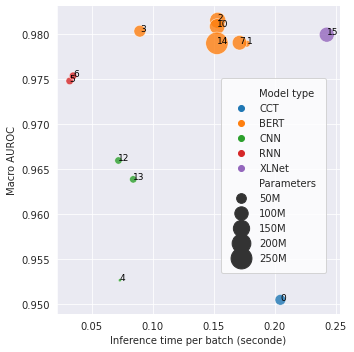

In [80]:
rename_label_dict = {
    "model_type":"Model type",
    "parameters":"Parameters",
    "0.5":"50M",
    "1.0":"100M",
    "1.5":"150M",
    "2.0":"200M",
    "2.5":"250M",
}

sns.set_style("darkgrid")

g = sns.relplot(
    data=clean_perf_and_params_per_model_df,
    x="batch_time", y="auroc_macro",
    size="parameters",
    hue="model_type", sizes=(10, 500),
    alpha=0.8,
)

for t in g._legend.texts:
    t.set_text(rename_label_dict.get(t.get_text(), t.get_text()))

g.ax.xaxis.grid(True)
g.ax.yaxis.grid(True)
plt.xlabel("Inference time per batch (seconde)")
plt.ylabel("Macro AUROC")

for k, v in clean_perf_and_params_per_model_df.iterrows():
    g.ax.annotate(k, (v.batch_time, v.auroc_macro),
                xytext=(0,0), textcoords='offset points',
                family='sans-serif', fontsize=9, color='black')


#sns.move_legend(g, "lower center", ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.3))
sns.move_legend(g, "center right", ncol=1, frameon=True, bbox_to_anchor=(0.8, 0.5), borderpad=1)

legend = g._legend
frame = legend.get_frame()
frame.set_facecolor('white')

plt.savefig('perf_and_params_per_model_df.pdf', bbox_inches='tight')
plt.show()

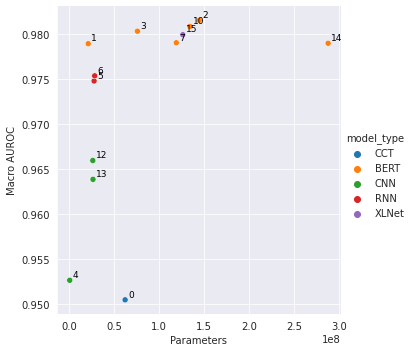

In [30]:
rename_label_dict = {
    "model_type":"Model type",
    "parameters":"Parameters",
    "0.5":"50M",
    "1.0":"100M",
    "1.5":"150M",
    "2.0":"200M",
    "2.5":"250M",
}

sns.set_style("darkgrid")


g = sns.relplot(
    data=clean_perf_and_params_per_model_df,
    x="parameters", y="auroc_macro",
    hue="model_type", sizes=(10, 500),
    alpha=1,
)

for t in g._legend.texts:
    t.set_text(rename_label_dict.get(t.get_text(), t.get_text()))
#g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True)
g.ax.yaxis.grid(True)
plt.xlabel("Parameters")
plt.ylabel("Macro AUROC")

#for i in range(perf_and_params_per_model_df.shape[0]):
#    g.ax.text(perf_and_params_per_model_df.batch_time[i] + 2, perf_and_params_per_model_df.auroc_macro[i] + 0.005, perf_and_params_per_model_df.index[i], horizontalalignment='center', size='medium', color='black', weight='semibold')

for k, v in clean_perf_and_params_per_model_df.iterrows():
    g.ax.annotate(k, (v.parameters, v.auroc_macro),
                xytext=(3,3), textcoords='offset points',
                family='sans-serif', fontsize=9, color='black')

#g.ax.annotate(, (2,0.960))
plt.savefig('perf_and_only_params_per_model_df.svg')
plt.show()

In [81]:
with open("number_model_map.log", "w") as f:
    f.write("\n".join([f"{i}. {name}" for i, name in enumerate(perf_and_params_per_model_df.session_name.to_list())]))

### Histograme AUC par modèle et par identité

In [114]:
model_type_dict = {session_name:model_type for session_name, model_type, _, _ in SELECTED_SESSION_INFO}

identity_aur_per_sub_per_model_df = groupby_test_df.progress_apply(identity_aur_per_sub_per_model)

identity_aur_per_sub_per_model_df.reset_index(inplace=True)
identity_aur_per_sub_per_model_df = identity_aur_per_sub_per_model_df.melt(id_vars=["session_name", "subgroup"], value_vars=["subgroup_auc", "bpsn_auc", "bnsp_auc"])
identity_aur_per_sub_per_model_df["model_type"] = identity_aur_per_sub_per_model_df.apply(lambda row: model_type_dict[row.session_name], axis=1)

  0%|          | 0/16 [00:00<?, ?it/s]

In [117]:
identity_aur_per_sub_per_model_df

,session_name,subgroup,variable,value,model_type
0,glove-cct-pwbce_2022-04-03T22-49-02-960730,male,subgroup_auc,0.878712,CCT
1,glove-cct-pwbce_2022-04-03T22-49-02-960730,female,subgroup_auc,0.880051,CCT
2,glove-cct-pwbce_2022-04-03T22-49-02-960730,black,subgroup_auc,0.772601,CCT
3,glove-cct-pwbce_2022-04-03T22-49-02-960730,white,subgroup_auc,0.792361,CCT
4,glove-cct-pwbce_2022-04-03T22-49-02-960730,homosexual_gay_or_lesbian,subgroup_auc,0.731388,CCT
...,...,...,...,...,...
427,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,homosexual_gay_or_lesbian,bnsp_auc,0.958170,XLNet
428,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,christian,bnsp_auc,0.950451,XLNet
429,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,jewish,bnsp_auc,0.964070,XLNet
430,pierre-xlnet-pwbce_2022-04-02T18-31-29-083854,muslim,bnsp_auc,0.959487,XLNet


In [118]:
# Rename session_name / subgroup
identity_aur_per_sub_per_model_df["session_name"] = identity_aur_per_sub_per_model_df["session_name"].apply(lambda session_name: session_name.split("_")[0])
identity_aur_per_sub_per_model_df["session_name"] = identity_aur_per_sub_per_model_df["session_name"].apply(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)

renam_subgroup_dict = {
    "homosexual_gay_or_lesbian":"homosexual",
    "psychiatric_or_mental_illness":"psychiatric"
}
identity_aur_per_sub_per_model_df["subgroup"] = identity_aur_per_sub_per_model_df["subgroup"].apply(lambda subgroup: renam_subgroup_dict.get(subgroup, subgroup))

In [123]:
identity_aur_per_sub_per_model_df

,session_name,subgroup,variable,value,model_type
0,glove-cct-pwbce,male,subgroup_auc,0.878712,CCT
1,glove-cct-pwbce,female,subgroup_auc,0.880051,CCT
2,glove-cct-pwbce,black,subgroup_auc,0.772601,CCT
3,glove-cct-pwbce,white,subgroup_auc,0.792361,CCT
4,glove-cct-pwbce,homosexual,subgroup_auc,0.731388,CCT
...,...,...,...,...,...
427,xlnet-pwbce,homosexual,bnsp_auc,0.958170,XLNet
428,xlnet-pwbce,christian,bnsp_auc,0.950451,XLNet
429,xlnet-pwbce,jewish,bnsp_auc,0.964070,XLNet
430,xlnet-pwbce,muslim,bnsp_auc,0.959487,XLNet


In [158]:
import plotly.express as px

labels={
    "subgroup_auc": "Sub. AUC",
    "bpsn_auc": "BPSN AUC",
    "bnsp_auc": "BNSP AUC",
    "subgroup":"",
    "model_type": "Model",
    "value":"AUC"
}

identity_aur_per_sub_per_type = identity_aur_per_sub_per_model_df.groupby(["model_type", "variable", "subgroup"]).mean().reset_index()

fig = px.bar(identity_aur_per_sub_per_type, x="subgroup", y="value", 
            color="model_type", barmode="group",
            facet_col="variable", labels=labels, range_y=[0.7, 1.0], width=800, height=1000, facet_col_wrap=1, 
            color_discrete_sequence=px.colors.qualitative.T10)

#sns.move_legend(g, "lower", ncol=2, frameon=True, bbox_to_anchor=(0.8, 0.5), borderpad=1)
#fig.update_traces(width=0.1)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=-0.05,
    xanchor="center",
    x=0.5
    ),
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    font={'size'   : 17}
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_annotation(lambda a: a.update(text=labels.get(a.text, a.text)))

fig.write_image("identity_aur_per_sub_per_model_df.pdf")
fig.show()



* La tableau des AUROC par classe (toxicity, obscene, ...) en fonction du modèle
* Le graph qui place les modèles de AUROC en fonction du nombre de paramètres, avec des points qui ont différentes couleurs en fonction de la famille du modèle (type BERT, type CNN, ...)

### Metric par classe

In [159]:
metric_per_class_per_model_df = groupby_test_df.progress_apply(metric_per_class_per_model)

  0%|          | 0/16 [00:00<?, ?it/s]

In [160]:
metric_per_class_per_model_df.index = metric_per_class_per_model_df.index.map(lambda session_name: session_name.split("_")[0])
metric_per_class_per_model_df.index = metric_per_class_per_model_df.index.map(lambda session_name: session_name[7:] if session_name.startswith("pierre-") else session_name)
metric_per_class_per_model_df.index.name = "Model"

rename_map = {
    "toxicity": "Toxicity",
    "obscene": "Obscene",
    "sexual_explicit": "Sexual Explicit",
    "identity_attack": "Identity Attack",
    "insult": "Insult",
    "threat": "Threat",
}
metric_per_class_per_model_df.rename(rename_map, inplace=True, axis=1)

In [ ]:
def bold_max_value(column):
    is_max_list = column == column.max()
    return ["font-weight: bold" if is_max else "" for is_max in is_max_list]

In [161]:
metric_per_class_per_model_style = metric_per_class_per_model_df.style.background_gradient(axis=0, cmap="PuBu_r")
metric_per_class_per_model_style = metric_per_class_per_model_style.format(precision=4)
metric_per_class_per_model_style = metric_per_class_per_model_style.apply(bold_max_value)


metric_per_class_per_model_style

,Toxicity,Obscene,Sexual Explicit,Identity Attack,Insult,Threat
Model,,,,,,
glove-cct-pwbce,0.9408,0.9682,0.9709,0.9681,0.9481,0.9067
albert-pwbce,0.9608,0.9893,0.9910,0.9806,0.9695,0.9825
bertweet-pwbce,0.9642,0.9904,0.9904,0.9882,0.9721,0.9840
distilbert-pwbce,0.9630,0.9889,0.9895,0.9869,0.9708,0.9831
freezed-glove-resnet44-pwbce,0.9321,0.9475,0.9637,0.9706,0.9477,0.9542
glove-bigru-pwbce,0.9569,0.9853,0.9856,0.9813,0.9672,0.9726
glove-bilstm-pwbce,0.9574,0.9860,0.9839,0.9826,0.9673,0.9752
hatebert-pwbce,0.9626,0.9878,0.9854,0.9869,0.9702,0.9815
roberta-bce,0.9643,0.9890,0.9910,0.9868,0.9719,0.9849


In [162]:
metric_per_class_per_model_latex = metric_per_class_per_model_style.to_latex(
    convert_css=True,
    column_format="lllllll",
    hrules=True,
)
print(metric_per_class_per_model_latex)

\begin{tabular}{lllllll}
\toprule
 & Toxicity & Obscene & Sexual Explicit & Identity Attack & Insult & Threat \\
Model &  &  &  &  &  &  \\
\midrule
glove-cct-pwbce & {\cellcolor[HTML]{0C74B2}} \color[HTML]{F1F1F1} 0.9408 & {\cellcolor[HTML]{69A5CC}} \color[HTML]{F1F1F1} 0.9682 & {\cellcolor[HTML]{0872B1}} \color[HTML]{F1F1F1} 0.9709 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9681 & {\cellcolor[HTML]{023B5D}} \color[HTML]{F1F1F1} 0.9481 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9067 \\
albert-pwbce & {\cellcolor[HTML]{EEE9F3}} \color[HTML]{000000} 0.9608 & {\cellcolor[HTML]{FAF2F8}} \color[HTML]{000000} 0.9893 & {\cellcolor[HTML]{FDF5FA}} \color[HTML]{000000} 0.9910 & {\cellcolor[HTML]{A5BDDB}} \color[HTML]{000000} 0.9806 & {\cellcolor[HTML]{EFE9F3}} \color[HTML]{000000} 0.9695 & {\cellcolor[HTML]{F9F2F8}} \color[HTML]{000000} 0.9825 \\
bertweet-pwbce & {\cellcolor[HTML]{FEF6FB}} \color[HTML]{000000} 0.9642 & {\cellcolor[HTML]{FEF6FA}} \color[HTML]{000000} 0.9904 & {